## Programa para hacer un histograma de S/N y ajustar el valor de $n_{ISS]$

Importamos los paquetes que vamos a usar

In [2]:
#-----------------------------------------
# importamos los paquetes que vamos a usar
#-----------------------------------------

import pypulse as pulsar

from lmfit import Model
from lmfit import Parameters, fit_report, minimize
from lmfit import Minimizer, Parameters, report_fit
from lmfit.models import ExpressionModel

import matplotlib.mlab as mlab
import matplotlib as mpl
import matplotlib.pyplot as plt     # para graficar
from matplotlib import pyplot

from scipy.optimize import curve_fit
import scipy.integrate as integrate

import math
import decimal
import numpy as np
import glob                         # para hacer listas de archivo
import subprocess                   # para usar subprocesos

#import pandas as pd

import os
import shutil

In [15]:
def f(x, n):
    
    S0 = np.mean(sn)
    return [norm * ( ((x_i  * n / S0)**(n)) / (x_i * math.gamma(n)) )  * math.exp( (-1.0 * x_i * n) / S0 ) * np.heaviside(x_i, 0) for x_i in x]

Cargamos los datos de entrada

In [9]:
ant = "A1"   # antena (A1, A2, o A1+A2)
t_min = 2000 # tiempo de integración mínimo considerado

datafile = "results_" + ant + "_subints_" + str(t_min) + ".txt"
files = np.loadtxt( datafile , skiprows=0 , dtype=str , usecols=(0) )
sn_obs = np.loadtxt( datafile , skiprows=0 , dtype=float , usecols=(1) )
t_obs = np.loadtxt( datafile , skiprows=0 , dtype=float , usecols=(2) )

Calculamos los S/N proyectados

In [10]:
sn = []
t_max = 216.970971429

for k in range(len(files)):

    sn.append(float(sn_obs[k] * math.sqrt(t_max / t_obs[k]) ))

Hacemos un binneado de intervalo de S/N y hacemos un gráfico preliminar del histograma

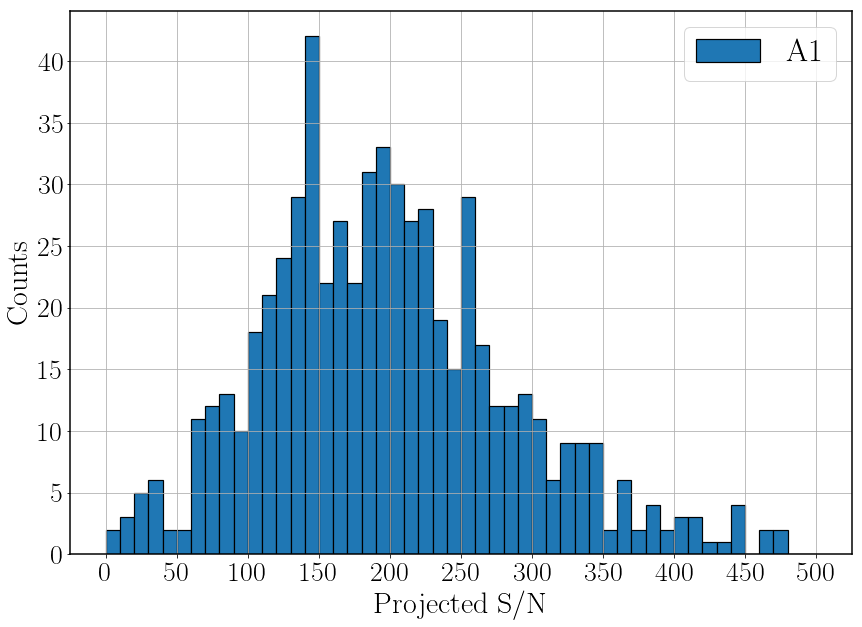

In [11]:
plt.close()

# Set the fonts. Always use big fonts.
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 30,
        "font.size": 28,
        "axes.linewidth": 1.5,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 32,
        "xtick.labelsize": 28,
        "ytick.labelsize": 28,
}
# Update the fonts
mpl.rcParams.update(nice_fonts)


plt.figure(figsize=(14,10))
plt.grid()
    
bin_width = 10                         # ancho del binneado
plt.xticks(np.arange(0, 510 , 50))
bins = np.arange(0, 510 , bin_width)   # tomamos un binneado uniforme del rango de valores de S/N

plt.hist(sn, bins, edgecolor='black', linewidth=1.2, label=ant)

plt.legend(loc='upper right')

plt.xlabel('Projected S/N')
plt.ylabel('Counts')
plt.show()

plt.close()

Normalizamos los datos

In [13]:
# Calculamos el número de observaciones dentro de cada uno de esos bins de S/N.

bin_heights, bin_borders, _ = plt.hist(sn, bins, edgecolor='black', linewidth=1.2, label=ant)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

# Normalizamos

norm = np.sum(bin_heights) * (bins[1] - bins[0])
bin_heights_norm = bin_heights / norm

parameter names: ['n']
independent variables: ['x']
[[Model]]
    Model(f)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 50
    # variables        = 1
    chi-square         = 749.295657
    reduced chi-square = 15.2917481
    Akaike info crit   = 137.355532
    Bayesian info crit = 139.267555
[[Variables]]
    n:  5.59236000 +/- 0.39690548 (7.10%) (init = 2.7)
749.2956571398594


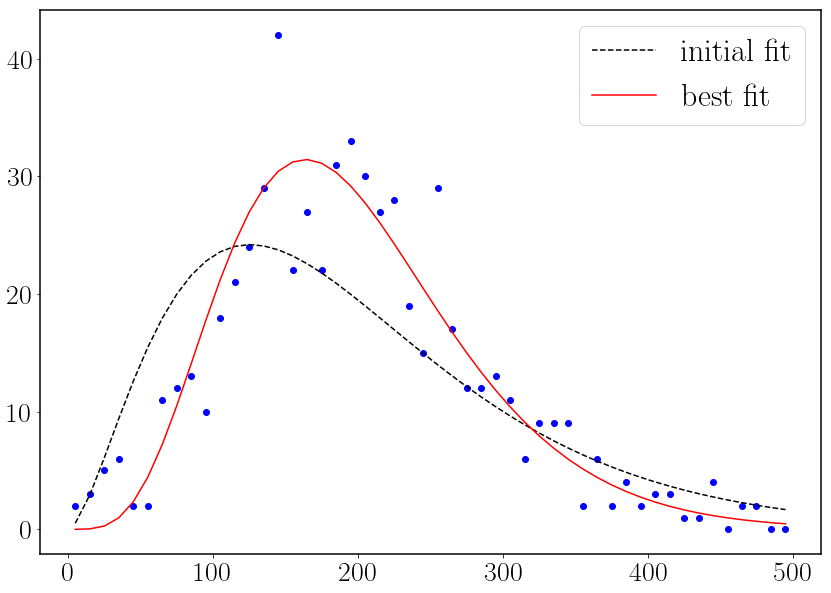

In [16]:
gmodel = Model(f)
print('parameter names: {}'.format(gmodel.param_names))
print('independent variables: {}'.format(gmodel.independent_vars))

params = gmodel.make_params(n=2.7)

result = gmodel.fit(bin_heights, x=bin_centers, n=2.7)

print(result.fit_report())
print(result.chisqr)

plt.close()
plt.figure(figsize=(14,10))
plt.plot(bin_centers, bin_heights, 'bo')
plt.plot(bin_centers, result.init_fit, 'k--', label='initial fit')
plt.plot(bin_centers, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

Graficamos el histograma junto al ajuste

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


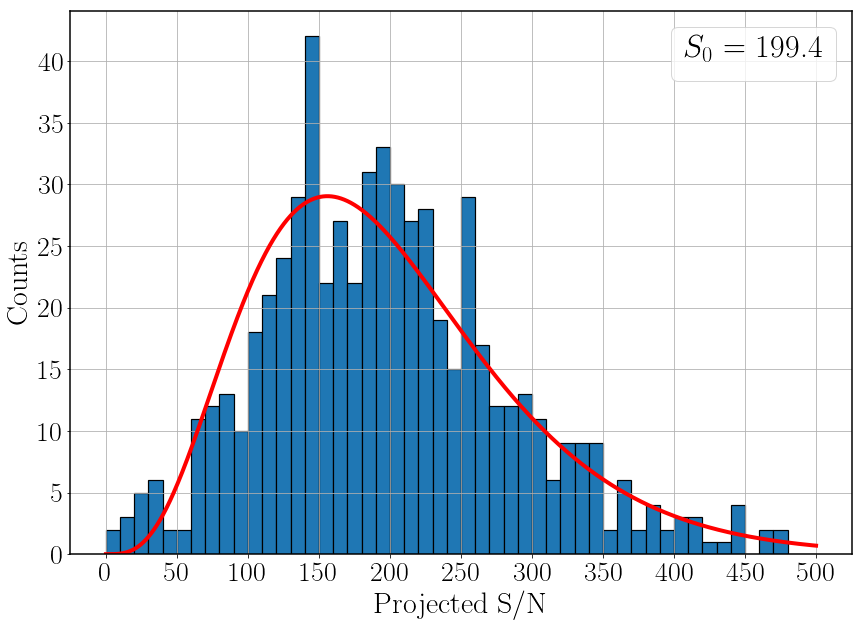

In [18]:
plt.close()

plt.figure(figsize=(14,10))
plt.grid()

if ant == "A1":
    col = "C0" 
elif ant == "A2":
    col = "darkorange"      
elif ant == "A1+A2":
    col = "green"

plt.xticks(np.arange(0, 510 , 50))
    
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, f(x_interval_for_fit, 4.59482892), lw=4, color='red')
plt.bar(bin_centers, bin_heights_norm * norm, width=bin_width, bottom=None, align='center', color=col, edgecolor='black', linewidth=1.2)
plt.plot([], [], ' ', label="$S_0$ = " + str(round(np.mean(sn),2)))
plt.legend(loc='upper right', handletextpad=0., handlelength=0)

plt.xlabel('Projected S/N')
plt.ylabel('Counts')

#plt.savefig('histograma_scintillation' + ant + '_subints_' + str(t_min) + '.pdf', bbox_inches='tight')
#plt.savefig('histograma_scintillation' + ant + '_subints_' + str(t_min) + '.png', bbox_inches='tight')

plt.show()
